# Notes on fitting the oscillatory particle model to the linear particle model
Tim Tyree<br>
1.15.2022

In [55]:
# TODO: simplify initialization
from scipy.optimize import minimize
from lib.my_initialization import *
from lib import *
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt, numpy as np
from mpltools import annotation
import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats

#for particle params to MSR generating functional
from scipy.signal import savgol_filter
import dask.bag as db
from lib.lib_care.measure.bootstrap import bin_and_bootstrap_xy_values_parallel

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

#optional
# import cupy as cp
# cp.random.seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part 1: Results consistent with the mean squared limit

In [62]:
G_over_T=1/6
z=2*np.pi*G_over_T
1+1/z+z/(1+z**2)

2.4543984211410783

In [101]:
# def comp_ahat_mslim(z,a,D,phi):
#     dasum=np.exp(1j*phi)/(1-1j*z)
#     dasum-=np.exp(-1j*phi)/(1+1j*z)
#     dasum-=np.sin(phi)
#     ahat=a+2*D/z*dasum.astype('float')
#     return ahat

# def comp_ahat_squared_mslim(z,a,D,phi):
#     squared_ahat_values =correction_diffusion(z,a=a,D=D,phi=phi)
#     squared_ahat_values+=correction_cross(z,a=a,D=D,phi=phi)
#     squared_ahat_values+=a**2
#     return np.sqrt(squared_ahat_values)

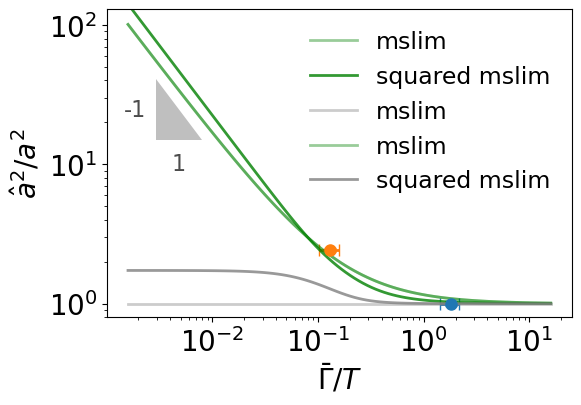

In [121]:
# # TODO: visualize ahat/a by summing the three terms of the attraction coefficient estimator
#plot solutions for the estimators
slope=-1
phi_f=-np.pi*0.5#-np.pi/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\hat a ^2/a^2$'#
use_loglog=True
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
z_values=np.logspace(-2,2,100)
x_values=z_values/(2.*np.pi)

# #plot observed ahat values as horizontal dashed lines
# y=ahat_fk_observed/a_fk_observed
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')

# #plot observed ahat,Gamma/T values as horizontal dashed lines
# #Fenton-Karma
# x=3
# Delta_x=.5 #poorly estimated uncertainty
# y=ahat_fk_observed/a_fk_observed
# Delta_y=.04 #well estimated uncertainty
#plot observed ahat,Gamma/T values as horizontal dashed lines
#Fenton-Karma
# GammaBar_observed: 387.0374+/-31.3052/2 milliseconds
# T:110 +/- ?? ms
a=197.3891#ms
Delta_GammaBar_observed=35.600166 #ms
# a=387.0374#ms
# Delta_GammaBar_observed=15.6526#ms
b=110#ms
Delta_T_estimated=10
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_fk_observed/a_fk_observed)
Delta_y=.04 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=8,capsize=4,lw=2,
            color='C0')#,label='Fenton-Karma')
# #Luo-Rudy
# x=0.1
# Delta_x=.05 #poorly estimated uncertainty
# y=ahat_lr_observed/a_lr_observed
# Delta_y=.08 #well estimated uncertainty
#Luo-Rudy
# GammaBar_observed: 41.9756+/-4.4809/2 milliseconds
# T:120 +/- ?? mc
# a=41.9756#ms
# Delta_GammaBar_observed=15.6526
a=15.5618 #ms
Delta_GammaBar_observed=1.867684
Delta_T_estimated=20
b=120#ms
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_lr_observed/a_lr_observed)
Delta_y=.08 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=8,capsize=4,lw=2,
            color='C1')#,label='Luo-Rudy')


#MSLIM
#plot predictions for phi=-np.pi/2
phi=phi_f
a=1 #same plot for any a
y_values= comp_ahat_mslim(z_values,a,D=a/2.,phi=phi)/a
ax.plot(x_values,y_values,lw=2,alpha=0.4,color='green',
                label=r'mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
        label=r'squared mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
#         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
#         label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
# #plot predictions for phi=0
# phi=0
a=1 #same plot for any a
y_values= comp_ahat_mslim(z_values,a,D=a/2.,phi=0)/a
ax.plot(x_values,y_values,lw=2,alpha=0.4,color='grey',
                label=r'mslim')

y_values= comp_ahat_mslim(z_values,a,D=a/2.,phi=phi)/a
ax.plot(x_values,y_values,lw=2,alpha=0.4,color='green',
                label=r'mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=0)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=0)
squared_ahat_values+=a**2
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
        label=r'squared mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')

#SMSLIM
# #plot predictions for phi=-np.pi/2
# phi=phi_f
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# y_values=np.sqrt(squared_ahat_values/a**2)
# ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
# #         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
# #         label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
# #plot predictions for phi=0
# phi=0
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# x_values=z_values/(2.*np.pi)
# y_values=np.sqrt(squared_ahat_values/a**2)
# ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
#         label=r'$g(\bar\Gamma/T,\phi_f=0)$')
# #         label=r'g($\phi_f=0$)')
# #         label=r'Solution ($\phi_f=0$)')



#DONE: copy estimates from .odg
#DONE: add error bar estimates
#TODO(later): consider improving x,Delta_x estimates
#TODO: plot the diffusion correction divided by the cross correction
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')
fontsize=20

#format_plot
# plt.title(r' $\phi_f=-\frac{\pi}{2}$',fontsize=18, x=0.8, y=0.9)
plt.ylim([8e-1,1.3e2])
ax.legend(loc='upper right',fontsize=fontsize-3,frameon=False)
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=use_loglog, fontsize=fontsize)#, **kwargs)
plt.tick_params(axis='y', which='minor',left=True)
plt.tick_params(axis='x', which='minor',bottom=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
## ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
##               direction='out', length=6, width=2, colors='k')
# mark_slope(ax=ax,x1=1e-2,y1=2e1,slope=(-1,1),invert=True)
mark_slope(ax=ax,x1=.8e-2,y1=1.5e1,slope=(-1,1),invert=True)
plt.show()

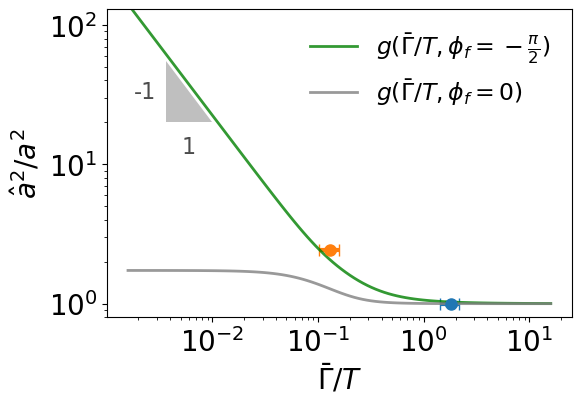

In [122]:
# # TODO: visualize ahat/a by summing the three terms of the attraction coefficient estimator
#plot solutions for the estimators
slope=-1
phi_f=-np.pi*0.5#-np.pi/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\hat a ^2/a^2$'#
use_loglog=True
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
z_values=np.logspace(-2,2,100)
x_values=z_values/(2.*np.pi)

# #plot observed ahat values as horizontal dashed lines
# y=ahat_fk_observed/a_fk_observed
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')

# #plot observed ahat,Gamma/T values as horizontal dashed lines
# #Fenton-Karma
# x=3
# Delta_x=.5 #poorly estimated uncertainty
# y=ahat_fk_observed/a_fk_observed
# Delta_y=.04 #well estimated uncertainty
#plot observed ahat,Gamma/T values as horizontal dashed lines
#Fenton-Karma
# GammaBar_observed: 387.0374+/-31.3052/2 milliseconds
# T:110 +/- ?? ms
a=197.3891#ms
Delta_GammaBar_observed=35.600166 #ms
# a=387.0374#ms
# Delta_GammaBar_observed=15.6526#ms
b=110#ms
Delta_T_estimated=10
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_fk_observed/a_fk_observed)
Delta_y=.04 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=8,capsize=4,lw=3,
            color='C0')#,label='Fenton-Karma')
# #Luo-Rudy
# x=0.1
# Delta_x=.05 #poorly estimated uncertainty
# y=ahat_lr_observed/a_lr_observed
# Delta_y=.08 #well estimated uncertainty
#Luo-Rudy
# GammaBar_observed: 41.9756+/-4.4809/2 milliseconds
# T:120 +/- ?? mc
# a=41.9756#ms
# Delta_GammaBar_observed=15.6526
a=15.5618 #ms
Delta_GammaBar_observed=1.867684
Delta_T_estimated=20
b=120#ms
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_lr_observed/a_lr_observed)
Delta_y=.08 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=8,capsize=4,lw=3,
            color='C1')#,label='Luo-Rudy')


#MSLIM
#plot predictions for phi=-np.pi/2
phi=phi_f
a=1 #same plot for any a
# y_values= comp_ahat_mslim(z_values,a,D=a/2.,phi=phi)/a
# ax.plot(x_values,y_values,lw=2,alpha=0.4,color='green',
#                 label=r'mslim')
# #         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# y_values=np.sqrt(squared_ahat_values/a**2)
# ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
#         label=r'squared mslim')
#         label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
#         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
#         label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
# #plot predictions for phi=0
# phi=0
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# x_values=z_values/(2.*np.pi)
# y_values=np.sqrt(squared_ahat_values/a**2)
# ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
#         label=r'$g(\bar\Gamma/T,\phi_f=0)$')
# #         label=r'g($\phi_f=0$)')
# #         label=r'Solution ($\phi_f=0$)')

# SMSLIM
#plot predictions for phi=-np.pi/2
phi=phi_f
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
        label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
#         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
#         label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
#plot predictions for phi=0
phi=0
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
x_values=z_values/(2.*np.pi)
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
        label=r'$g(\bar\Gamma/T,\phi_f=0)$')
#         label=r'g($\phi_f=0$)')
#         label=r'Solution ($\phi_f=0$)')



#DONE: copy estimates from .odg
#DONE: add error bar estimates
#TODO(later): consider improving x,Delta_x estimates
#TODO: plot the diffusion correction divided by the cross correction
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')
fontsize=20

#format_plot
# plt.title(r' $\phi_f=-\frac{\pi}{2}$',fontsize=18, x=0.8, y=0.9)
plt.ylim([8e-1,1.3e2])
ax.legend(loc='upper right',fontsize=fontsize-3,frameon=False)
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=use_loglog, fontsize=fontsize)#, **kwargs)
plt.tick_params(axis='y', which='minor',left=True)
plt.tick_params(axis='x', which='minor',bottom=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
## ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
##               direction='out', length=6, width=2, colors='k')
mark_slope(ax=ax,x1=1e-2,y1=2e1,slope=(-1,1),invert=True)
# mark_slope(ax=ax,x1=.8e-2,y1=1.5e1,slope=(-1,1),invert=True)
plt.show()

__Notes on fitting the oscillatory particle model to the linear particle model__
To develop a best-fit attraction coefficient of the particle model that is best fit to reproduce the powerlaw annihilation rates, we consider the Langevin equation with inverse-powerlaw attractive forces, $\sim\hat{a}/R$.  We show that $\hat{a}$ can be estimated to be 1/4 times the slope of the mean-squared range (MSR).

...of these interacting particles that attract then and pair-annihilate, we predict for the Fenton-Karma model being modeled by the oscillatory particle model with $\phi_f=\pi/2$, we have the analytical result, $\hat{a}=a$.  This supports the long-time averaged rate of change of MSR for the oscillatory particle model to be equal to that of the linear particle model, 

$$
\hat{a}_{FK}=a.
$$

A direct corollary of $\hat{a}_{FK}=a$ is that the expected annihilation rates are equal, and thus the mean termination time would be equal.

For the Luo-Rudy model, with annihilation phases of $\phi_f=0$, and dynamical period equal to mean lifetime, $T_{LR}=\bar\Gamma_{LR}$, we predict the best fit attraction coefficient of the particle model to be given by

$$
\hat{a}_{LR}=a + D \bigg(\frac{1}{1-\frac{i}{2\pi}} + \frac{1}{1+\frac{i}{2\pi}} \bigg) \approx a + (1.95059...)D.
$$

__Sketch of proof__:
What is the rate of change of MSR averaged over the lifetime of the particle? Let

$$
4\hat{a}\equiv\mathbb{E}_{\Gamma(t)}\Big[\partial_{t}MSR(t)\Big]=\frac{1}{\bar\Gamma}\int_0^\infty dt \Gamma(t) \partial_{t}MSR(t),
$$

where MSR is modeled by
$$
MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
$$

and where $\Gamma(t)$ is modeled by 

$$
\Gamma(t)=\bar\Gamma e^{-t/\bar\Gamma}.
$$

$$
\Gamma(t)=\frac{1}{\bar\Gamma} e^{-t/\bar\Gamma}
$$

In [123]:
# # MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# # DONE: plot ^this model for MSR for fitty parameter settings
# a=3.5;D=1.3;phi_f=0.;period=0.1 #s
# omega=2*np.pi/period
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f)
# plt.plot(t_values,MSR_values_oscillatory)
# plt.show()
# #TODO: plot for both of the full models
# #TODO: compare to the apparent results for MSR from the full models

In [124]:
msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# a_LR = 8.5950#+/-0.3771 cm^2/s
# tavg2=14 ms, num_samples=2083
msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# a_FK = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms

df_msd_lr=pd.read_csv(msr_dir_lr)
x_values_LR=df_msd_lr['tdeath_avg'].values
y_values_LR=df_msd_lr['MSR'].values
yerr_values_LR=df_msd_lr['Delta_MSR'].values
df_msd_fk=pd.read_csv(msr_dir_fk)
x_values_FK=df_msd_fk['tdeath_avg'].values
y_values_FK=df_msd_fk['MSR'].values
yerr_values_FK=df_msd_fk['Delta_MSR'].values

In [125]:
tmax=300#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_FK=a_SR

tmax=8#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

a_hat_FK = 1.604153+/-0.040173 cm^2/s, tmax=300
a_hat_LR = 8.595018+/-0.377114 cm^2/s, tmax=8


In [126]:
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

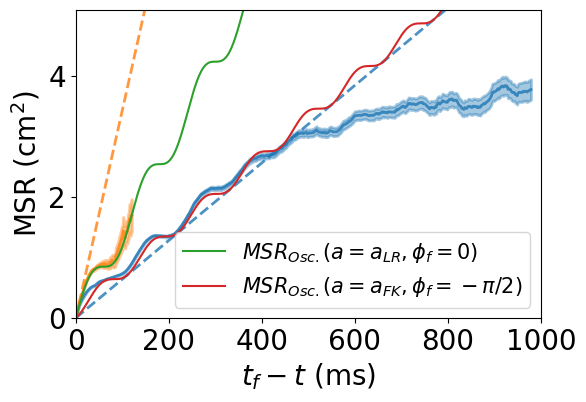

In [139]:
fontsize=15
fig,ax=plt.subplots(figsize=(6,4))
### plot expected
fontsize=20

xv=np.linspace(0,1e3,200)
ax.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
ax.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
ax.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
ax.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
ax.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
ax.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;
phi_f=0.;
# phi_f=-np.pi/2;
period=0.12 #s
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values*1e3,MSR_values_oscillatory,c='C2',
        label='$MSR_{Osc.} (a=a_{LR},\phi_f=0$)')
#         label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
ax.plot(t_values*1e3,MSR_values_oscillatory,c='C3',
        label='$MSR_{Osc.} (a=a_{FK}, \phi_f=-\pi/2$)')
#         label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=-\pi/2$)')

# #what param setting to use for the FK model?
# phi_f=0#-np.pi/2;
# # a=1.604153;
# # period=0.11 #s
# # D=a/2;
# # constant=0.15
# omega=2*np.pi/period
# constant=-8*D*np.sin(phi_f)/omega#0.15
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
# plt.plot(t_values*1e3,MSR_values_oscillatory,c='gray',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=0$)')

#format plot
format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
plt.xlim([0,1000])
plt.ylim([0,5.1])
plt.legend(loc='lower right',fontsize=fontsize-5)
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

In [ ]:
fig,ax=plt.subplots(figsize=(5,3))
# fig,ax=plt.subplots(figsize=(5,3))
### plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;phi_f=0.;period=0.12 #s
omega=2*np.pi/period
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))
plt.plot(t_values*1e3,MSR_values_oscillatory,c='C2',label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
period=0.11
D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
plt.plot(t_values*1e3,MSR_values_oscillatory,c='C3',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=-\pi/2$)')

#what param setting to use for the FK model?
phi_f=0#-np.pi/2;
# a=1.604153;
# period=0.11 #s
# D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
plt.plot(t_values*1e3,MSR_values_oscillatory,c='gray',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=0$)')

#format plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'Mean Squared Range (cm$^2$)',fontsize=14)
# format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,1000])
plt.ylim([0,5.1])
plt.legend(loc='lower right',fontsize=8)
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

In [ ]:
1

In [ ]:
### plot expected
xv=np.linspace(0,1e3,200)
plt.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
plt.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

# MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# DONE: plot ^this model for MSR for fitty parameter settings (LR)
# a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
a=3.535902;D=a/2;phi_f=0.;period=0.12 #s
omega=2*np.pi/period
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))
plt.plot(t_values*1e3,MSR_values_oscillatory,c='C2',label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

#what param setting to use for the FK model?
phi_f=-np.pi/2;
a=1.604153;
period=0.11 #s
D=a/2;
# constant=0.15
omega=2*np.pi/period
constant=-8*D*np.sin(phi_f)/omega#0.15
t_values=np.linspace(0,1,1000)
MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
plt.plot(t_values*1e3,MSR_values_oscillatory,c='C3',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=-\pi/2$)')

#what param setting to use for the FK model?
phi_f=0#-np.pi/2;
# a=1.604153;
# period=0.11 #s
# D=a/2;
# # constant=0.15
# omega=2*np.pi/period
# constant=-8*D*np.sin(phi_f)/omega#0.15
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
# plt.plot(t_values*1e3,MSR_values_oscillatory,c='gray',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=0$)')

#format plot
format_plot(ax=plt.gca(),xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)')
plt.xlim([0,150])
plt.ylim([0,1.1])
plt.legend(loc='lower right',fontsize=11)
plt.show()
# print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

$$
\text{MSR}_\text{Osc.}(t')=4at'+\frac{8D}{\omega}\Big(sin(\omega t' + \phi_f) - sin(\phi_f)\Big)
$$

$$
\hat a = a + D\Big( \frac{e^{i\phi_f}}{1-\frac{i}{\omega \bar\Gamma} } + \frac{e^{-i\phi_f}}{1+\frac{i}{\omega \bar\Gamma} } \Big)
$$

In [ ]:
a =3.535902 
period=0.1
barGamma=0.082733
omega=2*np.pi/period
a + a/2*(1.95),a + a/2*(1/(1-1j/(omega*barGamma))+1/(1+1j/(omega*barGamma)))

In [ ]:
barGamma=.0827333
T_values=np.linspace(0,1,100)
#TODO: plot ^this function 
x_values=T_values/barGamma
ahat_over_a_values=1+0.5*(1/(1-x_values*1j/(2*np.pi)) + 1/(1+x_values*1j/(2*np.pi)))
y_values=ahat_over_a_values

In [ ]:
plt.plot(x_values,y_values)
format_plot(ax=plt.gca(),xlabel=r'$T/\bar \Gamma$',ylabel=r'$\hat a/a$')

In [ ]:
120/80

In [ ]:
1+0.5*(1/(1-3j/(4*np.pi)) + 1/(1+3j/(4*np.pi)))

In [ ]:
8.5/1.946


In [ ]:
1+1.*(1/(1-3j/(4*np.pi)) + 1/(1+3j/(4*np.pi)))

In [ ]:
8.5/2.89

In [ ]:
# ahat_LR_over_a_LR
x=2*np.pi*84/120
# x=1
1+0.5*(1/(1-1j*x)-1/(1+1j*x))/1j


In [ ]:
# ahat_FK_over_a_LR
x=2*np.pi*310/110
# x=1
1+0.5*(-1j/(1-1j*x)-1j/(1+1j*x))/1j


In [ ]:
8.5/1.216

In [ ]:
(-1j/(1-1j*x)+1j/(1+1j*x))/1


## next logical step: determine if plugging ahat into the particle model gives the annihilation rates of the full models

$$
\hat a = a + \mathcal{J}D
$$

Where $\mathcal{J}_{FK}=0.112...$ and $\mathcal{J}_{LR}=1.95...$.

If $a=1.60...$ and $D=a/2$, then $\hat a_{FK}=1.69...$.

If $a=3.50...$ and $D=a/2$, then $\hat a_{LR}=6.91...$.

In [ ]:
1.60*(1+0.5*0.112)

In [ ]:
3.50*(1+0.5*1.95)

Contradiction...? I only found particle model solutions for 
$a \ge ~8.25$...

In [ ]:
3.50*(1+1*1.95)

In [ ]:
#maybe if I searched for larger D in the annihilation rates of the linear particle model?


## DONE: cointegrate the distribution of lifetimes with the mean squared range, as measured from the LR model

In [ ]:
# import cudf

In [ ]:
import pickle

lifetime_pdf_dir="/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/lifetimes.pkl"

# with open(lifetime_pdf_dir, 'wb') as handle:
#     pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(lifetime_pdf_dir, 'rb') as handle:
    dict_lifetimes = pickle.load(handle)


TODO(prereq): copy solution estimating ahat --> $\infty$ of z=Gammabar/T --> $0$ from iPad
$$
\hat{a}=a_{osc.} + \mathcal{J}(z;\phi_f) D_{osc.}
$$

__Sketch of Proof__

Let the mean-squared range (MSR) is the approximate solution to the the mean-squared, large sample limit of the the SDE corresponding to the oscillatory particle model

For $4\hat{a}\bar\Gamma \equiv \mathbb{E}_{\Gamma(t;\bar\Gamma)}\Big[\text{MSR}_{osc.}(t;T,a_{osc.},D_{osc.})\Big]$, we have

$$
\mathcal{J}(z;\phi_f) = \frac{e^{i\phi_f}}{1-2\pi iz} + \frac{e^{-i\phi_f}}{1+2\pi iz}.
$$

- DONE: checked ^the ansatz matches what I used on my iPad.

One can see that as $z\rightarrow0$, $\mathcal{J}(z;\phi_f) \rightarrow ??$.


TODO: estimate the z that gives ahat=<the ones I used in Fig. 1>.  For now, let
- ahat_LR=8.5, $\phi_f=0$
- ahat_FK=1.6, $\phi_f=-\pi/2$

# Part 2: Results consistent with the mean squared power spectrum limit

__Results from the mean squared power spectrum hypothesis__

The ansatz that demands self-consistency with respect to the mean squared power spectrum results in the following equation:
$$
\hat a^2 = a^2 + \delta a_\text{diffusion}^2 + \delta a_{\text{diffusion  }\times \text{ drift}}^2
$$

$$
\hat a^2 = a^2 + \delta a_\text{DD}^2 + \delta a_{Da}^2
$$

Where $\hat a$ is the effective attraction coefficient and $a$ is the attraction coefficient involved with the oscillatory model.  There emerged two correction factors. One was purely due to diffusion, $\delta a_\text{diffusion}$.  The other was due to the interaction between diffusion and drift, $\delta a_{\text{diffusion  }\times \text{ drift}}$.

Plotted are the boundary conditions for (blue) $\phi_f=-\pi/2$, and (orange) $\phi_f=0$.

Ansatz
$$
\mathbb{E}_{\Gamma(t)}\Big[\Big(\text{MSR}(t)\Big)^2\Big]_\text{linear}\overset{!}{=}\mathbb{E}_{\Gamma(t)}\Big[\Big(\text{MSR}(t)\Big)^2\Big]_\text{oscillatory},
$$
where
$$
\mathbb{E}_{\Gamma(t)}\Big[f(t)\Big]=\int_0^\infty \Big(\frac{e^{-t/\bar\Gamma}dt}{\bar\Gamma}\Big)f(t).
$$

## Plot the analytic solution for $\hat a$=ahat resulting from the mean squared power spectrum

### (ignore) first attempts at viewing the correction term due to diffusion...

In [2]:
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [3]:
# def correction_diffusion(z,a,D,phi):
#     """
#     correction_diffusion returns the real correction value 
#     that evaluates the expected attraction coefficient 
#     in terms of the parameters of the oscilatory model 
#     relative to the lifetime of the particle.
    
#     here, the lifetime of the particle has been taken 
#     to be exponentially distributed 
#     with an expected value 
#     proportional to z.
    
#     Note that z is also 
#     inversely proportional 
#     to the dynamic period of oscillation.
#     """
#     dasum=np.sin(phi)**2 - 2.*np.sin(phi)
#     dasum+=(1. + 4.*z**2 + 2.*z*np.sin(2.*phi) - np.cos(2.*phi))/(2.+8.*z**2)
#     dahat=2.*D**2/z**2
#     dahat*=dasum
#     return dahat

# def correction_diffusion_lr(z,a):
#     """
#     correction_diffusion_lr returns the correction 
#     to the attraction coefficient due to diffusion 
#     as the float expected 
#     in the mean squared power spectrum limit 
#     for parameters fit to the Luo-Rudy model.
#     """
#     return correction_diffusion(z,a,a/2.,phi=0.)

# def correction_diffusion_fk(z,a):
#     """
#     correction_diffusion_lr returns the correction 
#     to the attraction coefficient due to diffusion 
#     as the float expected 
#     in the mean squared power spectrum limit 
#     for parameters fit to the Fenton-Karma model.
#     """
#     return correction_diffusion(z,a,a/2.,phi=-np.pi/2.)

In [4]:
#heretim

In [5]:
a_hat_lr=8.5
a_hat_fk=1.6
print(F"TODO: add blue and orange curves for the a values expected of the full solution")
dz=0.1#0.01
z_values=np.arange(dz,3+dz,dz)
sdahat_values_lr=correction_diffusion_lr(z_values,a=a_hat_lr)
sdahat_values_fk=correction_diffusion_fk(z_values,a=a_hat_fk)

TODO: add blue and orange curves for the a values expected of the full solution


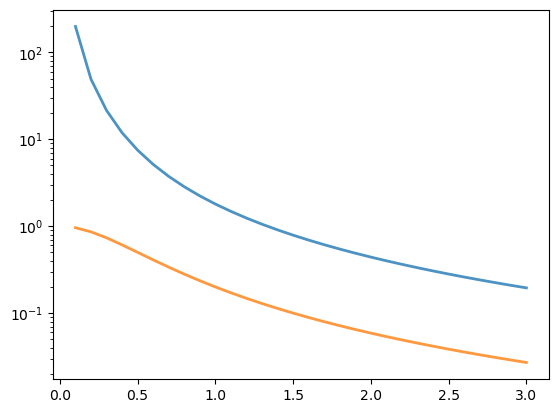

In [6]:
x_values=z_values.copy()
#plot the expected solutions
y_values_lr=sdahat_values_lr/a_hat_lr**2
y_values_fk=sdahat_values_fk/a_hat_fk**2
plt.plot(x_values,np.abs(y_values_fk),lw=2,alpha=0.8)
plt.plot(x_values,np.abs(y_values_lr),lw=2,alpha=0.8)
plt.yscale('log')
plt.show()

In [7]:
#DONE: plot dahat_over_a versus z
da=0.002#0.01
a_values=np.arange(da,4+da,da)

#eval correction_diffusion_lr
dahat_lst=[]
for a in a_values:
    dahat=correction_diffusion_lr(z_values,a)
    dahat_lst.append(dahat)
# dahat_over_a=np.divide(np.array(dahat_lst).T,a_values)
dahat_values=np.divide(np.array(dahat_lst).T,a_values)
dahat_values_lr=dahat_values.copy()

#eval correction_diffusion_fk
dahat_lst=[]
for a in a_values:
    dahat=correction_diffusion_fk(z_values,a)
    dahat_lst.append(dahat)
# dahat_over_a=np.divide(np.array(dahat_lst).T,a_values)
dahat_values=np.divide(np.array(dahat_lst).T,a_values)
dahat_values_fk=dahat_values.copy()

In [8]:
# test dahat_over_a_lr is nonnegative for diffusion term
assert not (dahat_values_lr<0).any()

# test dahat_over_a_lr has negative values for diffusion term
assert not (dahat_values_fk<0).any()

In [9]:
#DONE: visualize these traces for either model for ahat correction versus 2pi*(lifetime / dynamic period) as z
x_values=z_values.copy()/(2.*np.pi)
a_values_trgt=a_values[::40]#for  a_values.shape as (400,)
y_values_fk_lst=[]
y_values_lr_lst=[]
for a  in a_values_trgt:
    boo=a==a_values
    #compute
    y_values_fk=dahat_values_fk.T[boo][0]
    y_values_lr=dahat_values_lr.T[boo][0]
    #record
    y_values_fk_lst.append(y_values_fk)
    y_values_lr_lst.append(y_values_lr)

In [10]:
a_hat_lr=8.5
a_hat_fk=1.6
print(F"TODO: add blue and orange curves for the a values expected of the full solution")
dz=0.01
z_values=np.arange(dz,3+dz,dz)
sdahat_values_lr=correction_diffusion_lr(z_values,a=a_hat_lr)
sdahat_values_fk=correction_diffusion_fk(z_values,a=a_hat_fk)
#compute plotting values
y_values_lr=sdahat_values_lr/a_hat_lr**2
y_values_fk=sdahat_values_fk/a_hat_fk**2
c_values=a_values_trgt/np.max(a_values_trgt)
vmin=np.min(c_values)
vmax=np.max(c_values)

TODO: add blue and orange curves for the a values expected of the full solution


In [11]:
slope=-2#-1/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$-\delta \hat a_{D^2} ^2/a^2$'#  (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
fig,ax=plt.subplots(figsize=(5,3))
#plot the expected solutions
y_values_lr=sdahat_values_lr/a_hat_lr**2
y_values_fk=sdahat_values_fk/a_hat_fk**2
plt.plot(x_values,-y_values_fk,lw=2,alpha=0.8)
plt.plot(x_values,-y_values_lr,lw=2,alpha=0.8)
# #plot for variable a
#plot for variable a
for i,a in enumerate(a_values_trgt):
    plt.scatter(x_values,-y_values_fk_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greens',vmin=vmin,vmax=vmax)
    plt.scatter(x_values,-y_values_lr_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greys',vmin=vmin,vmax=vmax)
# c_values=a_values_trgt/np.max(a_values_trgt)
# for i,a in enumerate(a_values_trgt):
#     plt.scatter(x_values,-y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
#     plt.scatter(x_values,-y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible

#DONE: plot a token powerlaw that is positive and monotonically decreasing 
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(-3,0,100)
yv=1.5e-1*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([1e-4,1e7])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()

ValueError: x and y must have same first dimension, but have shapes (30,) and (300,)

In [ ]:
slope=-2#-1/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\delta \hat a_{D^2} ^2/a^2$'#  (cm$^2$/s)'
# ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  (cm$^2$/s)'
# ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
fig,ax=plt.subplots(figsize=(5,3))
#plot the expected solutions
plt.plot(x_values,y_values_fk,lw=2,alpha=0.8)
plt.plot(x_values,y_values_lr,lw=2,alpha=0.8)
# plt.plot(x_values,np.abs(y_values_fk),lw=2,alpha=0.8)
# plt.plot(x_values,np.abs(y_values_lr),lw=2,alpha=0.8)
#plot for variable a
for i,a in enumerate(a_values_trgt):
    plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greens',vmin=vmin,vmax=vmax)
    plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greys',vmin=vmin,vmax=vmax)
#     plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
#     plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible
#DONE: plot a token powerlaw that is positive and monotonically decreasing 
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(-3,0,100)
yv=1.5e-1*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([1e-4,1e7])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
mark_slope(ax=plt.gca(), x1=3e-1, y1=.35e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()

In [ ]:
slope=-2#-1/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
fig,ax=plt.subplots(figsize=(5,3))
#plot the expected solutions
plt.plot(x_values,np.abs(y_values_fk),lw=2,alpha=0.8)
plt.plot(x_values,np.abs(y_values_lr),lw=2,alpha=0.8)
#plot for variable a
for i,a in enumerate(a_values_trgt):
    plt.scatter(x_values,np.abs(y_values_fk_lst[i])/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greens',vmin=vmin,vmax=vmax)
    plt.scatter(x_values,np.abs(y_values_lr_lst[i])/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greys',vmin=vmin,vmax=vmax)
#     plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
#     plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible
#DONE: plot a token powerlaw that is positive and monotonically decreasing 
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(-3,0,100)
yv=1.5e-1*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([1e-4,1e7])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
mark_slope(ax=plt.gca(), x1=3e-1, y1=.35e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()

In [ ]:
# #TODO(Now!): implement the cross correction to ahat_squared
# def correction_cross(z,a,D,phi):
#     """
#     correction_cross returns the real correction value 
#     that evaluates the expected attraction coefficient 
#     in terms of the parameters of the oscilatory model 
#     relative to the lifetime of the particle.
    
#     here, the lifetime of the particle has been taken 
#     to be exponentially distributed 
#     with an expected value 
#     proportional to z.
    
#     z = 2 * pi * mean_lifetime / dynamic_period
    
#     Note that z is also 
#     inversely proportional 
#     to the dynamic period of oscillation.
#     """
#     dasum=(np.sin(phi) + 2.*z*np.cos(phi) - z**2*np.sin(phi))/((1. + z**2)**2)
#     dasum-=np.sin(phi)
#     dahat=D*a/z
#     dahat*=dasum
#     return dahat

# def correction_cross_lr(z,a):
#     """
#     correction_diffusion_lr returns the cross correction 
#     to the attraction coefficient 
#     as the float expected 
#     in the mean squared power spectrum limit 
#     for parameters fit to the Luo-Rudy model.
#     """
#     return correction_cross(z,a,a/2.,phi=0.)

# def correction_cross_fk(z,a):
#     """
#     correction_diffusion_lr returns the cross correction 
#     to the attraction coefficient 
#     as the float expected 
#     in the mean squared power spectrum limit 
#     for parameters fit to the Fenton-Karma model.
#     """
#     return correction_cross(z,a,a/2.,phi=-np.pi/2.)

# DONE: visualize the cross correction term

In [12]:
#reset matplotlib
import matplotlib
from matplotlib.ticker import FormatStrFormatter
matplotlib.rcParams.update(matplotlib.rcParamsDefault)


In [13]:
#GOAL: visualize the correction due to any cross terms
#DONE: confirm ^these functions with the equations on my ipad
#TODO: test ^these functions with the following cells


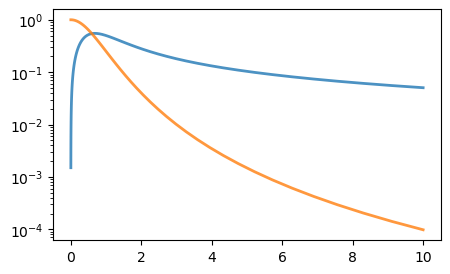

In [14]:
a_hat_lr=8.5
a_hat_fk=1.6
a_lr=3.5
a_fk=1.6
# # print(F"DONE: add blue and orange curves for the a values expected of the full solution")
# dz=0.1#0.01
# z_values=np.arange(dz,3+dz,dz)
z_values=np.logspace(-3,1,100)

sdahat_values_lr=correction_cross_lr(z_values,a=a_lr)
sdahat_values_fk=correction_cross_fk(z_values,a=a_fk)
sdahat_values_lr_cross=sdahat_values_lr.copy()
sdahat_values_fk_cross=sdahat_values_fk.copy()
x_values=z_values.copy()
#plot the expected solutions
y_values_lr=sdahat_values_lr/a_lr**2
y_values_fk=sdahat_values_fk/a_fk**2
plt.plot(x_values,np.abs(y_values_fk),lw=2,alpha=0.8)
plt.plot(x_values,np.abs(y_values_lr),lw=2,alpha=0.8)
plt.yscale('log')
# plt.ylim([0.,10])
plt.show()

In [15]:
#correction_cross versus a
# a_hat_lr=8.5
# a_hat_fk=1.6
# print(F"TODO: add blue and orange curves for the a values expected of the full solution")
# dz=0.01
# z_values=np.arange(dz,3+dz,dz)
# sdahat_values_lr=correction_cross_lr(z_values,a=a_hat_lr)
# sdahat_values_fk=correction_cross_fk(z_values,a=a_hat_fk)
# #compute plotting values
# y_values_lr=sdahat_values_lr/a_hat_lr**2
# y_values_fk=sdahat_values_fk/a_hat_fk**2


#DONE: plot dahat_over_a versus z
da=0.1#0.002#0.01
a_values=np.arange(da,7+da,da)

#eval correction_cross_lr
dahat_lst=[]
for a in a_values:
    dahat=correction_cross_lr(z_values,a)
#     dahat=correction_diffusion_lr(z_values,a)
    dahat_lst.append(dahat)
# dahat_over_a=np.divide(np.array(dahat_lst).T,a_values)
# dahat_values=np.divide(np.array(dahat_lst).T,a_values)
dahat_values=np.array(dahat_lst).T#.T,a_values)
dahat_values_lr=dahat_values.copy()

#eval correction_cross_fk
dahat_lst=[]
for a in a_values:
    dahat=correction_cross_fk(z_values,a)
    dahat_lst.append(dahat)
# dahat_over_a=np.divide(np.array(dahat_lst).T,a_values)
# dahat_values=np.divide(np.array(dahat_lst).T,a_values)
dahat_values=np.array(dahat_lst).T#.T,a_values)
dahat_values_fk=dahat_values.copy()

In [16]:
# test dahat_over_a_lr is nonnegative for correction term
assert not (dahat_values_lr<0).any()

# test dahat_over_a_lr  is nonnegative for correction term
assert not  (dahat_values_fk<0).any()

In [17]:
#DONE: visualize these traces for either model for ahat correction versus 2pi*(lifetime / dynamic period) as z
x_values=z_values.copy()/(2.*np.pi)
# a_values_trgt=a_values[::40]#for  a_values.shape as (400,)
a_values_trgt=a_values[::4]#for  a_values.shape as (400,)
y_values_fk_lst=[]
y_values_lr_lst=[]
for a  in a_values_trgt:
    boo=a==a_values
    #compute
    y_values_fk=dahat_values_fk.T[boo][0]
    y_values_lr=dahat_values_lr.T[boo][0]
    #record
    y_values_fk_lst.append(y_values_fk)
    y_values_lr_lst.append(y_values_lr)


c_values=a_values_trgt/np.max(a_values_trgt)
# c_values=np.exp(c_values)
vmin=np.min(c_values)
vmax=np.max(c_values)    

In [18]:
a_hat_lr=8.5
a_hat_fk=1.6
a_lr=3.5
a_fk=1.6
# # print(F"DONE: add blue and orange curves for the a values expected of the full solution")
# dz=0.1#0.01
# z_values=np.arange(dz,3+dz,dz)
# z_values=np.logspace(-3,1,100)

sdahat_values_lr=correction_cross_lr(z_values,a=a_lr)
sdahat_values_fk=correction_cross_fk(z_values,a=a_fk)
sdahat_values_lr_cross=sdahat_values_lr.copy()
sdahat_values_fk_cross=sdahat_values_fk.copy()
x_values=z_values.copy()
#plot the expected solutions
y_values_lr=sdahat_values_lr/a_lr**2
y_values_fk=sdahat_values_fk/a_fk**2

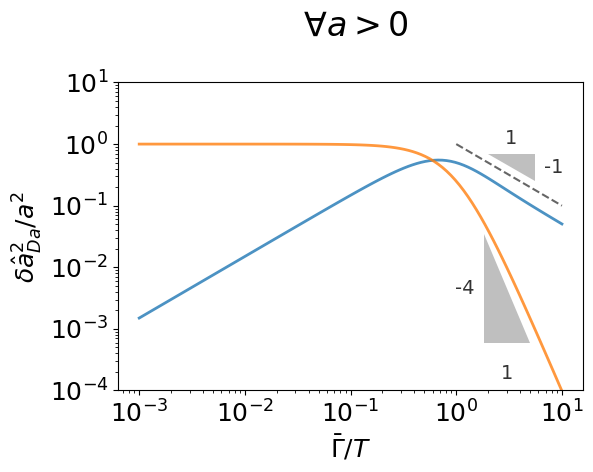

In [19]:
slope=-1#-1/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\delta \hat a_{Da} ^2/a^2$'#  (cm$^2$/s)'
# ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  (cm$^2$/s)'
# ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
#plot the expected solutions
plt.plot(x_values,y_values_fk,lw=2,alpha=0.8)
plt.plot(x_values,y_values_lr,lw=2,alpha=0.8)
# # plt.plot(x_values,np.abs(y_values_fk),lw=2,alpha=0.8)
# # plt.plot(x_values,np.abs(y_values_lr),lw=2,alpha=0.8)
# #plot for variable a
# for i,a in enumerate(a_values_trgt):
#     plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greens',vmin=vmin,vmax=vmax)
#     plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greys',vmin=vmin,vmax=vmax)
# #     plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# #     plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# DONE: each colored by a_values_trgt
# DONT: on a scale with both ends clearly visible
#DONE: plot a token powerlaw that is positive and monotonically decreasing
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(0,1,20)
yv=1.e-0*xv**slope
# yv=5e-0*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.title(r' $\forall a>0$'+'\n',fontsize=24)
# plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
# plt.ylim([1e-4,1e7])
plt.ylim([1e-4,1e1])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
#LR
mark_slope(ax=plt.gca(), x1=5e-0, y1=6e-4, slope=(-4,1),invert=True, text_kwargs={'color': 'black','fontsize':14, "alpha":0.8})#, poly_kwargs={'facecolor': (0.0, 0.0, 0)})#)
#FK
mark_slope(ax=plt.gca(), x1=2e-0, y1=.7e0, slope=(slope,1), text_kwargs={'color': 'black','fontsize':14, "alpha":0.8})#, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=3e-1, y1=.23e1, slope=(slope,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=3e-1, y1=.75e0, slope=(slope,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=3e-1, y1=.35e1, slope=(slope,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
#force minor ticks to be on for the log y axis
plt.tick_params(axis='y', which='minor',left=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
## ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
##               direction='out', length=6, width=2, colors='k')
plt.show()

# DONE: visualize the pure diffusion correction term

- can i assume ahat/a is independent of a, again? Supposing $a=2D$, Yes.

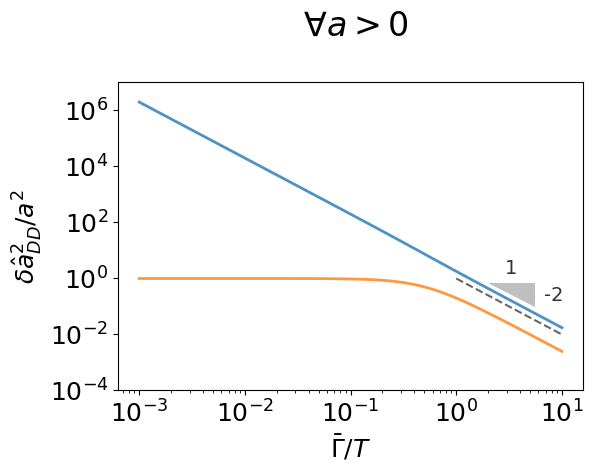

In [20]:
#GOAL: visualize the correction purely due to any diffusion
a_hat_lr=8.5
a_hat_fk=1.6
a_lr=3.5
a_fk=1.6
# # print(F"DONE: add blue and orange curves for the a values expected of the full solution")
# dz=0.1#0.01
# z_values=np.arange(dz,3+dz,dz)
z_values=np.logspace(-3,1,100)

# sdahat_values_lr=correction_cross_lr(z_values,a=a_lr)
# sdahat_values_fk=correction_cross_fk(z_values,a=a_fk)
# sdahat_values_lr_cross=sdahat_values_lr.copy()
# sdahat_values_fk_cross=sdahat_values_fk.copy()
# x_values=z_values.copy()
# #plot the expected solutions
# y_values_lr=sdahat_values_lr/a_lr**2
# y_values_fk=sdahat_values_fk/a_fk**2
# plt.plot(x_values,np.abs(y_values_fk),lw=2,alpha=0.8)
# plt.plot(x_values,np.abs(y_values_lr),lw=2,alpha=0.8)
# plt.yscale('log')
# # plt.ylim([0.,10])
# plt.show()

#correction_cross versus a
# a_hat_lr=8.5
# a_hat_fk=1.6
# print(F"TODO: add blue and orange curves for the a values expected of the full solution")
# dz=0.01
# z_values=np.arange(dz,3+dz,dz)
# sdahat_values_lr=correction_cross_lr(z_values,a=a_hat_lr)
# sdahat_values_fk=correction_cross_fk(z_values,a=a_hat_fk)
# #compute plotting values
# y_values_lr=sdahat_values_lr/a_hat_lr**2
# y_values_fk=sdahat_values_fk/a_hat_fk**2


#DONE: plot dahat_over_a versus z
da=0.1#0.002#0.01
a_values=np.arange(da,7+da,da)

#eval correction_diffusion_lr
dahat_lst=[]
for a in a_values:
    dahat=correction_diffusion_lr(z_values,a)
    dahat_lst.append(dahat)
# dahat_over_a=np.divide(np.array(dahat_lst).T,a_values)
# dahat_values=np.divide(np.array(dahat_lst).T,a_values)
dahat_values=np.array(dahat_lst).T#.T,a_values)
dahat_values_lr=dahat_values.copy()

#eval correction_cross_fk
dahat_lst=[]
for a in a_values:
    dahat=correction_diffusion_fk(z_values,a)
    dahat_lst.append(dahat)
# dahat_over_a=np.divide(np.array(dahat_lst).T,a_values)
# dahat_values=np.divide(np.array(dahat_lst).T,a_values)
dahat_values=np.array(dahat_lst).T#.T,a_values)
dahat_values_fk=dahat_values.copy()

# test dahat_over_a_lr is nonnegative for correction term
assert not (dahat_values_lr<0).any()

# test dahat_over_a_lr  is nonnegative for correction term
assert not  (dahat_values_fk<0).any()

#DONE: visualize these traces for either model for ahat correction versus 2pi*(lifetime / dynamic period) as z
x_values=z_values.copy()/(2.*np.pi)
# a_values_trgt=a_values[::40]#for  a_values.shape as (400,)
a_values_trgt=a_values[::4]#for  a_values.shape as (400,)
y_values_fk_lst=[]
y_values_lr_lst=[]
for a  in a_values_trgt:
    boo=a==a_values
    #compute
    y_values_fk=dahat_values_fk.T[boo][0]
    y_values_lr=dahat_values_lr.T[boo][0]
    #record
    y_values_fk_lst.append(y_values_fk)
    y_values_lr_lst.append(y_values_lr)


c_values=a_values_trgt/np.max(a_values_trgt)
# c_values=np.exp(c_values)
vmin=np.min(c_values)
vmax=np.max(c_values)    

a_hat_lr=8.5
a_hat_fk=1.6
a_lr=3.5
a_fk=1.6
# # print(F"DONE: add blue and orange curves for the a values expected of the full solution")
# dz=0.1#0.01
# z_values=np.arange(dz,3+dz,dz)
# z_values=np.logspace(-3,1,100)

sdahat_values_lr=correction_diffusion_lr(z_values,a=a_lr)
sdahat_values_fk=correction_diffusion_fk(z_values,a=a_fk)
sdahat_values_lr_diffusion=sdahat_values_lr.copy()
sdahat_values_fk_diffusion=sdahat_values_fk.copy()
x_values=z_values.copy()
#plot the expected solutions
y_values_lr=sdahat_values_lr/a_lr**2
y_values_fk=sdahat_values_fk/a_fk**2

slope=-2
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\delta \hat a_{DD} ^2/a^2$'#
# ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  
# ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
#plot the expected solutions
plt.plot(x_values,y_values_fk,lw=2,alpha=0.8)
plt.plot(x_values,y_values_lr,lw=2,alpha=0.8)
# # plt.plot(x_values,np.abs(y_values_fk),lw=2,alpha=0.8)
# # plt.plot(x_values,np.abs(y_values_lr),lw=2,alpha=0.8)
# #plot for variable a
# for i,a in enumerate(a_values_trgt):
#     plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greens',vmin=vmin,vmax=vmax)
#     plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greys',vmin=vmin,vmax=vmax)
# #     plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# #     plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# DONE: each colored by a_values_trgt
# DONT: on a scale with both ends clearly visible
#DONE: plot a token powerlaw that is positive and monotonically decreasing
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(0,1,20)
yv=1.e-0*xv**slope
# yv=5e-0*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.title(r' $\forall a>0$'+'\n',fontsize=24)
# plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([1e-4,1e7])
# plt.ylim([1e-4,1e1])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
#LR
# mark_slope(ax=plt.gca(), x1=5e-0, y1=6e-4, slope=(-2,1),invert=True, text_kwargs={'color': 'black','fontsize':14, "alpha":0.8})#, poly_kwargs={'facecolor': (0.0, 0.0, 0)})#)
#FK
mark_slope(ax=plt.gca(), x1=2e-0, y1=.7e0, slope=(slope,1), text_kwargs={'color': 'black','fontsize':14, "alpha":0.8})#, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=3e-1, y1=.23e1, slope=(slope,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=3e-1, y1=.75e0, slope=(slope,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=3e-1, y1=.35e1, slope=(slope,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
#force minor ticks to be on for the log y axis
plt.tick_params(axis='y', which='minor',left=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
## ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
##               direction='out', length=6, width=2, colors='k')
plt.show()

In [21]:
assert not (y_values_lr<0).any()
assert not (y_values_fk<0).any()

# generate a panel for Fig. 3

In [72]:
a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()
# note: a_ratio_lr=a_hat_FK_vlong/a_hat_FK_vlong=1
ahat_fk_observed=a_hat_FK_vlong
D_hat_fk_observed=D_hat_FK
ahat_lr_observed=a_hat_LR
D_hat_lr_observed=D_hat_LR
a_lr_observed=a_hat_LR_long
a_fk_observed=a_hat_FK_vlong

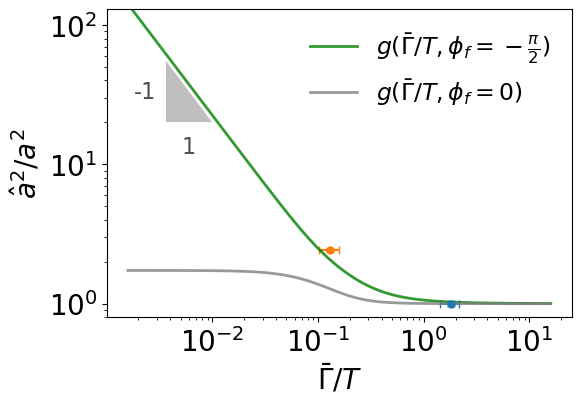

In [94]:
# # TODO: visualize ahat/a by summing the three terms of the attraction coefficient estimator
#plot solutions for the estimators
slope=-1
phi_f=-np.pi*0.5#-np.pi/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\hat a ^2/a^2$'#
a=1 #same plot for any a
use_loglog=True
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
z_values=np.logspace(-2,2,100)
x_values=z_values/(2.*np.pi)

# #plot observed ahat values as horizontal dashed lines
# y=ahat_fk_observed/a_fk_observed
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')

# #plot observed ahat,Gamma/T values as horizontal dashed lines
# #Fenton-Karma
# x=3
# Delta_x=.5 #poorly estimated uncertainty
# y=ahat_fk_observed/a_fk_observed
# Delta_y=.04 #well estimated uncertainty
#plot observed ahat,Gamma/T values as horizontal dashed lines
#Fenton-Karma
# GammaBar_observed: 387.0374+/-31.3052/2 milliseconds
# T:110 +/- ?? ms
a=197.3891#ms
Delta_GammaBar_observed=36.3267 #ms
# a=387.0374#ms
# Delta_GammaBar_observed=15.6526#ms
b=110#ms
Delta_T_estimated=10
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_fk_observed/a_fk_observed)
Delta_y=.04 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=5,capsize=3,
            color='C0')#,label='Fenton-Karma')
# #Luo-Rudy
# x=0.1
# Delta_x=.05 #poorly estimated uncertainty
# y=ahat_lr_observed/a_lr_observed
# Delta_y=.08 #well estimated uncertainty
#Luo-Rudy
# GammaBar_observed: 41.9756+/-4.4809/2 milliseconds
# T:120 +/- ?? mc
# a=41.9756#ms
# Delta_GammaBar_observed=15.6526
a=15.5618 #ms
Delta_GammaBar_observed=1.9058
Delta_T_estimated=20
b=120#ms
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_lr_observed/a_lr_observed)
Delta_y=.08 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=5,capsize=3,
            color='C1')#,label='Luo-Rudy')


#plot predictions for phi=-np.pi/2
phi=phi_f
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
        label=r'$g(\bar\Gamma/T,\phi_f=-\frac{\pi}{2})$')
#         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
#         label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
#plot predictions for phi=0
phi=0
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
x_values=z_values/(2.*np.pi)
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
        label=r'$g(\bar\Gamma/T,\phi_f=0)$')
#         label=r'g($\phi_f=0$)')
#         label=r'Solution ($\phi_f=0$)')



#DONE: copy estimates from .odg
#DONE: add error bar estimates
#TODO(later): consider improving x,Delta_x estimates
#TODO: plot the diffusion correction divided by the cross correction
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')
fontsize=20

#format_plot
# plt.title(r' $\phi_f=-\frac{\pi}{2}$',fontsize=18, x=0.8, y=0.9)
plt.ylim([8e-1,1.3e2])
ax.legend(loc='upper right',fontsize=fontsize-3,frameon=False)
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=use_loglog, fontsize=fontsize)#, **kwargs)
plt.tick_params(axis='y', which='minor',left=True)
plt.tick_params(axis='x', which='minor',bottom=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
## ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
##               direction='out', length=6, width=2, colors='k')
mark_slope(ax=ax,x1=1e-2,y1=2e1,slope=(-1,1),invert=True)
plt.show()

In [ ]:
# # TODO: visualize ahat/a by summing the three terms of the attraction coefficient estimator
#plot solutions for the estimators
slope=-1
phi_f=-np.pi*0.5#-np.pi/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\hat a ^2/a^2$'#
a=1 #same plot for any a
use_loglog=True
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
z_values=np.logspace(-2,2,100)
x_values=z_values/(2.*np.pi)

# #plot observed ahat values as horizontal dashed lines
# y=ahat_fk_observed/a_fk_observed
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')

#plot predictions for phi=-np.pi/2
phi=phi_f
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
y_values=np.sqrt(squared_ahat_values/a**2)
# ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
#         label=r'$g(\bar\Gammma/T,\phi_f=-\frac{\pi}{2})$')
#         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
#         label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
#plot predictions for phi=0
phi=0
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
x_values=z_values/(2.*np.pi)
y_values=np.sqrt(squared_ahat_values/a**2)
# ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
#         label=r'$g(\bar\Gammma/T,\phi_f=0)$')
#         label=r'g($\phi_f=0$)')
#         label=r'Solution ($\phi_f=0$)')


# #plot observed ahat,Gamma/T values as horizontal dashed lines
# #Fenton-Karma
# x=3
# Delta_x=.5 #poorly estimated uncertainty
# y=ahat_fk_observed/a_fk_observed
# Delta_y=.04 #well estimated uncertainty
#plot observed ahat,Gamma/T values as horizontal dashed lines
#Fenton-Karma
# GammaBar_observed: 387.0374+/-31.3052/2 milliseconds
# T:110 +/- ?? ms
a=197.3891#ms
Delta_GammaBar_observed=36.3267 #ms
# a=387.0374#ms
# Delta_GammaBar_observed=15.6526#ms
b=110#ms
Delta_T_estimated=10
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_fk_observed/a_fk_observed)
Delta_y=.04 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=5,capsize=3,
            color='C0',
            label='Fenton-Karma')
# #Luo-Rudy
# x=0.1
# Delta_x=.05 #poorly estimated uncertainty
# y=ahat_lr_observed/a_lr_observed
# Delta_y=.08 #well estimated uncertainty
#Luo-Rudy
# GammaBar_observed: 41.9756+/-4.4809/2 milliseconds
# T:120 +/- ?? mc
# a=41.9756#ms
# Delta_GammaBar_observed=15.6526
a=15.5618 #ms
Delta_GammaBar_observed=1.9058
Delta_T_estimated=10
b=120#ms
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_lr_observed/a_lr_observed)
Delta_y=.08 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=5,capsize=3,
            color='C1',
            label='Luo-Rudy')
#DONE: copy estimates from .odg
#DONE: add error bar estimates
#TODO(later): consider improving x,Delta_x estimates
#TODO: plot the diffusion correction divided by the cross correction
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')


#format_plot
# plt.title(r' $\phi_f=-\frac{\pi}{2}$',fontsize=18, x=0.8, y=0.9)
plt.ylim([8e-1,1.3e2])
ax.legend(loc='upper right',fontsize=11,frameon=False)
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=use_loglog, fontsize=18)#, **kwargs)
plt.tick_params(axis='y', which='minor',left=True)
plt.tick_params(axis='x', which='minor',bottom=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
## ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
##               direction='out', length=6, width=2, colors='k')
mark_slope(ax=ax,x1=1e-2,y1=2e1,slope=(-1,1),invert=True)
plt.show()

# DONE: repeat ^^this plot for the square root of the sum of the three terms
- TODO: why am i getting the same values for ahat/a?
- TODO: if I set phi=-np.pi, does ahat/a become large enough to support ahat_min_lr=8.25 ?

In [65]:
#compute by summing the three terms of the attraction coefficient estimator
squared_ahat_values_lr =correction_diffusion_lr(z_values,a=a_lr)
squared_ahat_values_lr+=correction_cross_lr(z_values,a=a_lr)
sdahat_over_a_squared_values_lr=squared_ahat_values_lr/a_lr**2
squared_ahat_values_lr+=a_lr**2

squared_ahat_values_fk =correction_diffusion_lr(z_values,a=a_fk)
squared_ahat_values_fk+=correction_cross_lr(z_values,a=a_fk)
sdahat_over_a_squared_values_fk=squared_ahat_values_lr/a_fk**2
squared_ahat_values_fk+=a_fk**2

In [66]:
#define xy axes
x_values=z_values.copy()/(2*np.pi)
y_values_fk=np.sqrt(squared_ahat_values_fk/a_fk**2)
y_values_lr=np.sqrt(squared_ahat_values_lr/a_lr**2)

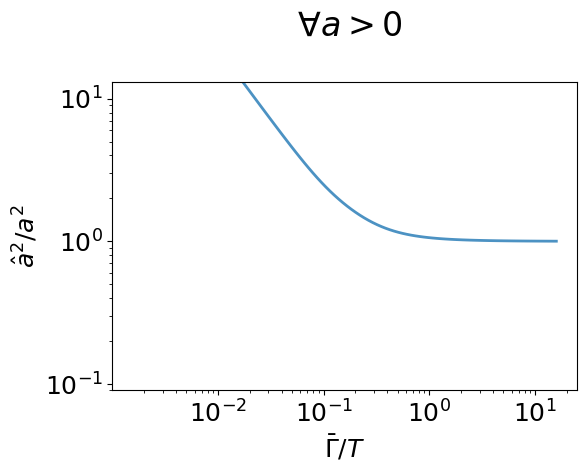

In [67]:
# # TODO: visualize ahat/a by summing the three terms of the attraction coefficient estimator
#plot solutions for the estimators
slope=-1
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\hat a ^2/a^2$'#
# use_loglog=False
use_loglog=True
# ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  
# ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
# #plot the expected solutions
# ax.plot(x_values,y_values_fk,lw=2,alpha=0.8)
# ax.plot(x_values,y_values_lr,lw=2,alpha=0.8)


#compute values for general phi
a=1
phi=-np.pi/2
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8)


#format_plot
plt.title(r' $\forall a>0$'+'\n',fontsize=24)
# plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([9e-2,1.3e1])
# plt.ylim([1e-4,1e1])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=use_loglog, fontsize=18)#, **kwargs)
#LR
# mark_slope(ax=plt.gca(), x1=5e-0, y1=6e-4, slope=(-2,1),invert=True, text_kwargs={'color': 'black','fontsize':14, "alpha":0.8})#, poly_kwargs={'facecolor': (0.0, 0.0, 0)})#)
#FK
# mark_slope(ax=plt.gca(), x1=2e-0, y1=.7e0, slope=(slope,1), text_kwargs={'color': 'black','fontsize':14, "alpha":0.8})#, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=3e-1, y1=.23e1, slope=(slope,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=3e-1, y1=.75e0, slope=(slope,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=3e-1, y1=.35e1, slope=(slope,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
#force minor ticks to be on for the log y axis
plt.tick_params(axis='y', which='minor',left=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
## ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
##               direction='out', length=6, width=2, colors='k')
plt.show()

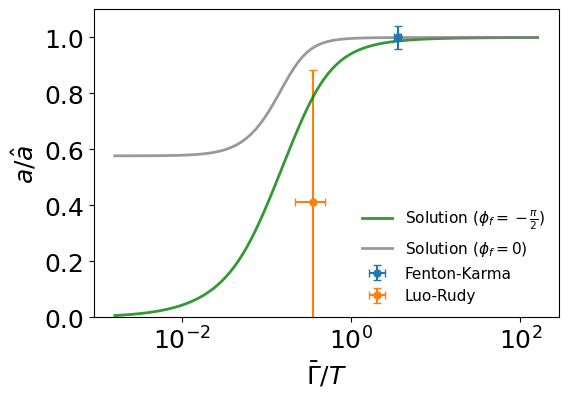

In [68]:
# # TODO: visualize a/ahat by summing the three terms of the attraction coefficient estimator
#plot solutions for the estimators
slope=-1
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$a /\hat a$'#
a=1 #same plot for any a
use_loglog=False
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
z_values=np.logspace(-2,3,100)
x_values=z_values/(2.*np.pi)

# #plot observed ahat values as horizontal dashed lines
# y=ahat_fk_observed/a_fk_observed
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')

#plot predictions for phi=-np.pi/2
phi=-np.pi/2
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
y_values=np.sqrt(squared_ahat_values/a**2)
y_values=y_values**-1
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
#plot predictions for phi=0
phi=0
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
x_values=z_values/(2.*np.pi)
y_values=np.sqrt(squared_ahat_values/a**2)
y_values=y_values**-1
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',label=r'Solution ($\phi_f=0$)')


#plot observed ahat,Gamma/T values as horizontal dashed lines
#Fenton-Karma
# GammaBar_observed: 387.0374+/-31.3052/2 milliseconds
# T:110 +/- ?? ms
Delta_GammaBar_observed=15.6526
Delta_T_estimated=10
a=387.0374#ms
b=110#ms
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_fk_observed/a_fk_observed)**-1
Delta_y=.04 #well estimated uncertainty for ahat/a
Delta_y/=y**2
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=5,capsize=3,
            color='C0',
            label='Fenton-Karma')
#Luo-Rudy
# GammaBar_observed: 41.9756+/-4.4809/2 milliseconds
# T:120 +/- ?? mc
Delta_GammaBar_observed=15.6526
Delta_T_estimated=10
a=41.9756#ms
b=120#ms
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_lr_observed/a_lr_observed)**-1
Delta_y=.08 #well estimated uncertainty for ahat/a
Delta_y/=y**2
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=5,capsize=3,
            color='C1',
            label='Luo-Rudy')
#DONE: copy estimates from .odg
#DONE: add error bar estimates
#TODO(later): consider improving x,Delta_x estimates
#TODO: plot the diffusion correction divided by the cross correction
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')


#format_plot
# plt.title(r' $\phi_f=-\frac{\pi}{2}$',fontsize=18, x=0.8, y=0.9)
# plt.ylim([8e-1,1.3e2])
plt.ylim([0,1.1])
ax.legend(loc='lower right',fontsize=11,frameon=False)
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=use_loglog, fontsize=18)#, **kwargs)
plt.tick_params(axis='y', which='minor',left=True)
plt.tick_params(axis='x', which='minor',bottom=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax.set_xscale('log')
# ax.set_yscale('log')
# plt.tick_params(axis='y', which='minor')
## ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
##               direction='out', length=6, width=2, colors='k')
# mark_slope(ax=ax,x1=1e-2,y1=1e1,slope=(-1,1),invert=True)
plt.show()

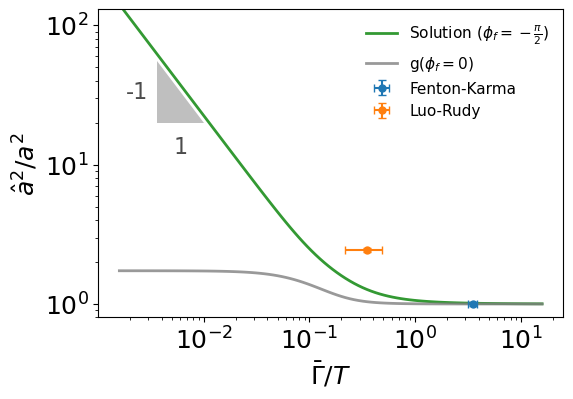

In [71]:
# # TODO: visualize ahat/a by summing the three terms of the attraction coefficient estimator
#plot solutions for the estimators
slope=-1
phi_f=-np.pi*0.5#-np.pi/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\hat a ^2/a^2$'#
a=1 #same plot for any a
use_loglog=True
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
z_values=np.logspace(-2,2,100)
x_values=z_values/(2.*np.pi)

# #plot observed ahat values as horizontal dashed lines
# y=ahat_fk_observed/a_fk_observed
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')

#plot predictions for phi=-np.pi/2
phi=phi_f
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',
#         label=r'g($\phi_f=$'+f"{phi_f:.4f})")
        label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
#plot predictions for phi=0
phi=0
squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
x_values=z_values/(2.*np.pi)
y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',
        label=r'g($\phi_f=0$)')
#         label=r'Solution ($\phi_f=0$)')


# #plot observed ahat,Gamma/T values as horizontal dashed lines
# #Fenton-Karma
# x=3
# Delta_x=.5 #poorly estimated uncertainty
# y=ahat_fk_observed/a_fk_observed
# Delta_y=.04 #well estimated uncertainty
#plot observed ahat,Gamma/T values as horizontal dashed lines
#Fenton-Karma
# GammaBar_observed: 387.0374+/-31.3052/2 milliseconds
# T:110 +/- ?? ms
Delta_GammaBar_observed=15.6526
Delta_T_estimated=10
a=387.0374#ms
b=110#ms
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_fk_observed/a_fk_observed)
Delta_y=.04 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=5,capsize=3,
            color='C0',
            label='Fenton-Karma')
# #Luo-Rudy
# x=0.1
# Delta_x=.05 #poorly estimated uncertainty
# y=ahat_lr_observed/a_lr_observed
# Delta_y=.08 #well estimated uncertainty
#Luo-Rudy
# GammaBar_observed: 41.9756+/-4.4809/2 milliseconds
# T:120 +/- ?? mc
Delta_GammaBar_observed=15.6526
Delta_T_estimated=10
a=41.9756#ms
b=120#ms
Delta_a=Delta_GammaBar_observed
Delta_b=Delta_T_estimated
x=a/b
Delta_x=np.sqrt(Delta_a**2/(b**2) + a**2*Delta_b**2/(b**4)) #well estimated uncertainty
y=(ahat_lr_observed/a_lr_observed)
Delta_y=.08 #well estimated uncertainty for ahat/a
ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=5,capsize=3,
            color='C1',
            label='Luo-Rudy')
#DONE: copy estimates from .odg
#DONE: add error bar estimates
#TODO(later): consider improving x,Delta_x estimates
#TODO: plot the diffusion correction divided by the cross correction
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')


#format_plot
# plt.title(r' $\phi_f=-\frac{\pi}{2}$',fontsize=18, x=0.8, y=0.9)
plt.ylim([8e-1,1.3e2])
ax.legend(loc='upper right',fontsize=11,frameon=False)
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=use_loglog, fontsize=18)#, **kwargs)
plt.tick_params(axis='y', which='minor',left=True)
plt.tick_params(axis='x', which='minor',bottom=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
## ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
##               direction='out', length=6, width=2, colors='k')
mark_slope(ax=ax,x1=1e-2,y1=2e1,slope=(-1,1),invert=True)
plt.show()

In [70]:
ratio_lr=1
Delta_ratio_fk=np.sqrt(2)*(0.04/1.60)
ratio_lr=ahat_lr_observed/a_lr_observed
Delta_ratio_lr=np.sqrt(2)*(0.3/np.sqrt(3.5*8.5))

ratio_lr,Delta_ratio_lr

(2.4307800385870424, 0.07778444682625973)

In [175]:
#compute ahat values for given phi,a,z using a=2D
print(f"fitting effective attraction coefficient to oscillatory attraction coefficients...")
# Luo-Rudy model
a=a_lr_observed
phi=-np.pi/2
print(f"\nLuo-Rudy model:")
print(f"parameter values: phi_f:{phi:.4f}, a: {a:.4f}")

G_over_T=1e-1
z=2*np.pi*G_over_T
squared_ahat_values =correction_diffusion(z=2*np.pi*G_over_T,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z=2*np.pi*G_over_T,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
ahat=np.sqrt(squared_ahat_values)#/a**2)
print(f"parameter values: Mean Lifetime / Dynamic Period: {G_over_T}")
print(f"parameter values: phi_f:{phi:.4f}, GammaBar/T: {G_over_T}")
print(f"predicted ahat: {ahat:.4f}")
print(f"observed ahat:  {ahat_lr_observed:.4f} (LR)")
print(f"disagreement:  {ahat_lr_observed-ahat:.4f} (LR)")

#compute ahat values for given phi,a,z using a=2D
G_over_T=1.03e-1
z=2*np.pi*G_over_T
squared_ahat_values =correction_diffusion(z,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
ahat=np.sqrt(squared_ahat_values)#/a**2)
print(f"parameter values: phi_f:{phi:.4f}, GammaBar/T: {G_over_T}")
print(f"predicted ahat: {ahat:.4f}")
print(f"observed ahat:  {ahat_lr_observed:.4f} (LR)")
print(f"disagreement:  {ahat_lr_observed-ahat:.4f} (LR)")

#Fenton-Karma model
#compute ahat values for given phi,a,z using a=2D
a=a_fk_observed
phi=-np.pi/2
print(f"\nFenton-Karma model:")
print(f"parameter values: phi_f:{phi:.4f}, a: {a:.4f}")

G_over_T=1
z=2*np.pi*G_over_T
squared_ahat_values =correction_diffusion(z=2*np.pi*G_over_T,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z=2*np.pi*G_over_T,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
ahat=np.sqrt(squared_ahat_values)#/a**2)
print(f"parameter values: Mean Lifetime / Dynamic Period: {G_over_T}")
print(f"parameter values: phi_f:{phi:.4f}, GammaBar/T: {G_over_T}")
print(f"predicted ahat: {ahat:.4f}")
print(f"observed ahat:  {ahat_fk_observed:.4f} (FK)")
print(f"disagreement:  {ahat_fk_observed-ahat:.4f} (FK)")

#compute ahat values for given phi,a,z using a=2D
G_over_T=3
z=2*np.pi*G_over_T
squared_ahat_values =correction_diffusion(z,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
ahat=np.sqrt(squared_ahat_values)#/a**2)
print(f"parameter values: phi_f:{phi:.4f}, GammaBar/T: {G_over_T}")
print(f"predicted ahat: {ahat:.4f}")
print(f"observed ahat:  {ahat_fk_observed:.4f} (FK)")
print(f"disagreement:  {ahat_fk_observed-ahat:.4f} (FK)")

fitting effective attraction coefficient to oscillatory attraction coefficients...

Luo-Rudy model:
parameter values: phi_f:-1.5708, a: 3.5359
parameter values: Mean Lifetime / Dynamic Period: 0.1
parameter values: phi_f:-1.5708, GammaBar/T: 0.1
predicted ahat: 8.8232
observed ahat:  8.5950 (LR)
disagreement:  -0.2282 (LR)
parameter values: phi_f:-1.5708, GammaBar/T: 0.103
predicted ahat: 8.6257
observed ahat:  8.5950 (LR)
disagreement:  -0.0307 (LR)

Fenton-Karma model:
parameter values: phi_f:-1.5708, a: 1.6042
parameter values: Mean Lifetime / Dynamic Period: 1
parameter values: phi_f:-1.5708, GammaBar/T: 1
predicted ahat: 1.7021
observed ahat:  1.6042 (FK)
disagreement:  -0.0979 (FK)
parameter values: phi_f:-1.5708, GammaBar/T: 3
predicted ahat: 1.6292
observed ahat:  1.6042 (FK)
disagreement:  -0.0251 (FK)


In [162]:
#compute ahat values for given phi,a,z using a=2D
a=a_lr_observed
phi=-np.pi/2
print(f"fitting effective attraction coefficient to oscillatory attraction coefficient for Luo-Rudy model:")
print(f"parameter values: phi_f:{phi:.4f}, a: {a:.4f}")
G_over_T=1e-0
z=2*np.pi*G_over_T
squared_ahat_values =correction_diffusion(z,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
ahat=np.sqrt(squared_ahat_values)#/a**2)
# print(f"parameter values: phi_f:{phi:.4f}, GammaBar/T: {G_over_T}")
# print(f"predicted ahat/a: {ahat:.4f}")
# print(f"observed ahat/a: {1.6/1.6:.4f} (FK)")
# print(f"")
print(f"parameter values: phi_f:{phi:.4f}, GammaBar/T: {G_over_T}")
print(f"predicted ahat: {ahat:.4f}")
print(f"observed ahat: {ahat_fk_observed:.4f} (FK)")
print(f"disagreement: {ahat_fk_observed-ahat:.4f} (FK)")
#compute ahat values for given phi,a,z using a=2D
G_over_T=3e-0
z=2*np.pi*G_over_T
squared_ahat_values =correction_diffusion(z,a=a,D=a/2.,phi=phi)
squared_ahat_values+=correction_cross(z,a=a,D=a/2.,phi=phi)
squared_ahat_values+=a**2
ahat=np.sqrt(squared_ahat_values)#/a**2)
# print(f"parameter values: phi_f:{phi:.4f}, GammaBar/T: {G_over_T}")
# print(f"predicted ahat/a: {ahat:.4f}")
# print(f"observed ahat/a: {1.6/1.6:.4f} (FK)")
print(f"")
print(f"parameter values: phi_f:{phi:.4f}, GammaBar/T: {G_over_T}")
print(f"predicted ahat: {ahat:.4f}")
print(f"observed ahat: {ahat_fk_observed:.4f} (FK)")
print(f"disagreement: {ahat_fk_observed-ahat:.4f} (FK)")

fitting effective attraction coefficient to oscillatory attraction coefficient for Luo-Rudy model:
parameter values: phi_f:-1.5708, a: 3.5359
parameter values: phi_f:-1.5708, GammaBar/T: 1.0
predicted ahat: 3.7517
observed ahat: 1.6042 (FK)
disagreement: -2.1476 (FK)

parameter values: phi_f:-1.5708, GammaBar/T: 3.0
predicted ahat: 3.5912
observed ahat: 1.6042 (FK)
disagreement: -1.9871 (FK)


# Visualize dahat_DD/dahat_Da vs. Gammabar/T
for (green) solution with phif=-pi/2 and for (gray) solution with phif=-pi/2

In [ ]:
# Visualize dahat_DD/dahat_Da vs. Gammabar/T
# for (green) solution with phif=-pi/2 and for (gray) solution with phif=-pi/2

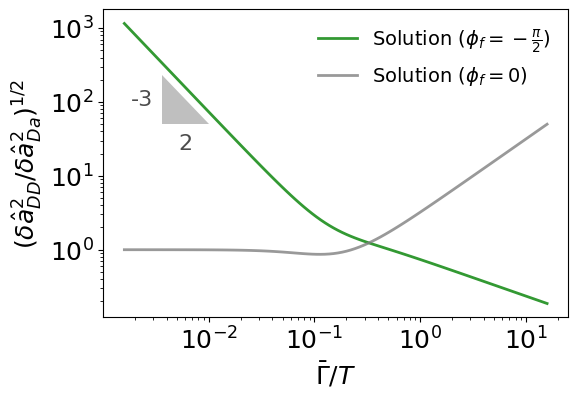

In [220]:
# # TODO: visualize ahat/a by summing the three terms of the attraction coefficient estimator
#plot solutions for the estimators
slope=-1
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$(\delta\hat a_{DD} ^2/ \delta\hat a_{Da}^2)^{1/2}$'#
# ylabel=r'$\sqrt{\delta\hat a_{DD} ^2/ \delta\hat a_{Da}^2}$'#
a=1 #same plot for any a
use_loglog=True
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
z_values=np.logspace(-2,2,100)
x_values=z_values/(2.*np.pi)

# #plot observed ahat values as horizontal dashed lines
# y=ahat_fk_observed/a_fk_observed
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')

#plot predictions for phi=-np.pi/2
phi=-np.pi/2
y_values=correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
y_values/=correction_cross(z_values,a=a,D=a/2.,phi=phi)
y_values=np.sqrt(y_values)
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# x_values=z_values/(2.*np.pi)
# y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
#plot predictions for phi=0
phi=0
y_values=correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
y_values/=correction_cross(z_values,a=a,D=a/2.,phi=phi)
y_values=np.sqrt(y_values)
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# x_values=z_values/(2.*np.pi)
# y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',label=r'Solution ($\phi_f=0$)')


# #plot observed ahat,Gamma/T values as horizontal dashed lines
# #Fenton-Karma
# x=3
# Delta_x=.5 #poorly estimated uncertainty
# y=ahat_fk_observed/a_fk_observed
# Delta_y=.04 #well estimated uncertainty
# ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=5,capsize=3,
#             color='C0',
#             label='Fenton-Karma')
# #Luo-Rudy
# x=0.1
# Delta_x=.05 #poorly estimated uncertainty
# y=ahat_lr_observed/a_lr_observed
# Delta_y=.08 #well estimated uncertainty
# ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=5,capsize=3,
#             color='C1',
#             label='Luo-Rudy')
# #DONE: copy estimates from .odg
# #DONE: add error bar estimates
# #TODO(later): consider improving x,Delta_x estimates
# #TODO: plot the diffusion correction divided by the cross correction
# # ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# # y=ahat_lr_observed/a_lr_observed
# # ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')


#format_plot
# plt.title(r' $\phi_f=-\frac{\pi}{2}$',fontsize=18, x=0.8, y=0.9)
# plt.ylim([8e-1,1.3e2])
# ax.legend(loc='upper right',fontsize=11,frameon=False)
ax.legend(loc='upper right',fontsize=14,frameon=False)
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=use_loglog, fontsize=18)#, **kwargs)
plt.tick_params(axis='y', which='minor',left=True)
plt.tick_params(axis='x', which='minor',bottom=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
# ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
# ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
#               direction='out', length=6, width=2, colors='k')
mark_slope(ax=ax,x1=1e-2,y1=0.5e2,slope=(-3,2),invert=True)
plt.show()

In [ ]:
#TODO: visualize the fraction of the effective attraction coefficient that is coming from the pure drift term
#frac=a/ahat
#plot solutions for the estimators
slope=-1
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$(\delta\hat a_{DD} ^2/ \delta\hat a_{Da}^2)^{1/2}$'#
# ylabel=r'$\sqrt{\delta\hat a_{DD} ^2/ \delta\hat a_{Da}^2}$'#
a=1 #same plot for any a
use_loglog=True
# fig,ax=plt.subplots(figsize=(5,3))
fig,ax=plt.subplots(figsize=(6,4))
z_values=np.logspace(-2,2,100)
x_values=z_values/(2.*np.pi)

# #plot observed ahat values as horizontal dashed lines
# y=ahat_fk_observed/a_fk_observed
# ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# y=ahat_lr_observed/a_lr_observed
# ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')

#plot predictions for phi=-np.pi/2
phi=-np.pi/2
y_values=correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
y_values/=correction_cross(z_values,a=a,D=a/2.,phi=phi)
y_values=np.sqrt(y_values)
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# x_values=z_values/(2.*np.pi)
# y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='green',label=r'Solution ($\phi_f=-\frac{\pi}{2}$)')
#plot predictions for phi=0
phi=0
y_values=correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
y_values/=correction_cross(z_values,a=a,D=a/2.,phi=phi)
y_values=np.sqrt(y_values)
# squared_ahat_values =correction_diffusion(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=correction_cross(z_values,a=a,D=a/2.,phi=phi)
# squared_ahat_values+=a**2
# x_values=z_values/(2.*np.pi)
# y_values=np.sqrt(squared_ahat_values/a**2)
ax.plot(x_values,y_values,lw=2,alpha=0.8,color='gray',label=r'Solution ($\phi_f=0$)')


# #plot observed ahat,Gamma/T values as horizontal dashed lines
# #Fenton-Karma
# x=3
# Delta_x=.5 #poorly estimated uncertainty
# y=ahat_fk_observed/a_fk_observed
# Delta_y=.04 #well estimated uncertainty
# ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=5,capsize=3,
#             color='C0',
#             label='Fenton-Karma')
# #Luo-Rudy
# x=0.1
# Delta_x=.05 #poorly estimated uncertainty
# y=ahat_lr_observed/a_lr_observed
# Delta_y=.08 #well estimated uncertainty
# ax.errorbar(x, y, xerr=Delta_x, yerr=Delta_y, fmt='o',markersize=5,capsize=3,
#             color='C1',
#             label='Luo-Rudy')
# #DONE: copy estimates from .odg
# #DONE: add error bar estimates
# #TODO(later): consider improving x,Delta_x estimates
# #TODO: plot the diffusion correction divided by the cross correction
# # ax.plot(x_values,0.*x_values+y,'C0--',lw=2,alpha=0.9,label='Fenton-Karma Model')
# # y=ahat_lr_observed/a_lr_observed
# # ax.plot(x_values,0.*x_values+y,'C1--',lw=2,alpha=0.9,label='Luo-Rudy Model')


#format_plot
# plt.title(r' $\phi_f=-\frac{\pi}{2}$',fontsize=18, x=0.8, y=0.9)
# plt.ylim([8e-1,1.3e2])
# ax.legend(loc='upper right',fontsize=11,frameon=False)
ax.legend(loc='upper right',fontsize=14,frameon=False)
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=use_loglog, fontsize=18)#, **kwargs)
plt.tick_params(axis='y', which='minor',left=True)
plt.tick_params(axis='x', which='minor',bottom=True)
# ax.set_yticks([1e-4,1e-3,1e-2,1e-1,1e0,1e1])
# ax.set_yscale('log')
plt.tick_params(axis='y', which='minor')
# ax.tick_params(axis='y',reset=False, left=True,right=False, which='minor',
#               direction='out', length=6, width=2, colors='k')
mark_slope(ax=ax,x1=1e-2,y1=0.5e2,slope=(-3,2),invert=True)
plt.show()

## TODO: look for a mean lifetime that is consistent with an exponentially distributed lifetime and the MSD of the full model

In [ ]:
#TODO: compute 3.5/1.6 
expected_ahat_squared_ratio= (3.5/1.6 )**2
print(f"expected_ahat_squared_ratio={expected_ahat_squared_ratio}")

### scratchwerk

In [ ]:
mark_slope

In [ ]:
slope=-2#-1/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$-\delta \hat a_{D^2} ^2/a^2$'#  (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
fig,ax=plt.subplots(figsize=(5,3))
#plot the expected solutions
y_values_lr=sdahat_values_lr/a_hat_lr**2
y_values_fk=sdahat_values_fk/a_hat_fk**2
plt.plot(x_values,-y_values_fk,lw=2,alpha=0.8)
plt.plot(x_values,-y_values_lr,lw=2,alpha=0.8)
# #plot for variable a
#plot for variable a
for i,a in enumerate(a_values_trgt):
    plt.scatter(x_values,-y_values_fk_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greens',vmin=vmin,vmax=vmax)
    plt.scatter(x_values,-y_values_lr_lst[i]/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greys',vmin=vmin,vmax=vmax)
# c_values=a_values_trgt/np.max(a_values_trgt)
# for i,a in enumerate(a_values_trgt):
#     plt.scatter(x_values,-y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
#     plt.scatter(x_values,-y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible

#DONE: plot a token powerlaw that is positive and monotonically decreasing 
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(-3,0,100)
yv=1.5e-1*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([1e-4,1e7])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()

In [ ]:
slope=-1
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$|\delta \hat a_{D^2}| ^2/a^2$'#  (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
fig,ax=plt.subplots(figsize=(5,3))
#plot the expected solutions
plt.plot(x_values,np.abs(y_values_fk),lw=2,alpha=0.8)
plt.plot(x_values,np.abs(y_values_lr),lw=2,alpha=0.8)
#plot for variable a
for i,a in enumerate(a_values_trgt):
    plt.scatter(x_values,np.abs(y_values_fk_lst[i])/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greens',vmin=vmin,vmax=vmax)
    plt.scatter(x_values,np.abs(y_values_lr_lst[i])/(a**2),c=1.*c_values[i]+0.*x_values,linestyle='dotted',alpha=alpha,s=5,cmap='Greys',vmin=vmin,vmax=vmax)
#     plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
#     plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible
#DONE: plot a token powerlaw that is positive and monotonically decreasing 
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(-3,0,100)
yv=1.5e-1*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
# plt.ylim([1e-4,1e7])
# plt.xlim([])
plt.ylim([1e-5,1e7])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
mark_slope(ax=plt.gca(), x1=3e-1, y1=.75e0, slope=(slope,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=3e-1, y1=.35e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()

## scratchwerk

In [ ]:
slope=-2#-1/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$-\delta \hat a_{D^2} ^2/a^2$'#  (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
fig,ax=plt.subplots(figsize=(5,3))
#plot the expected solutions
y_values_lr=sdahat_values_lr/a_hat_lr**2
y_values_fk=sdahat_values_fk/a_hat_fk**2
plt.plot(x_values,y_values_fk,lw=2,alpha=0.8)
plt.plot(x_values,y_values_lr,lw=2,alpha=0.8)
#plot for variable a
c_values=a_values_trgt/np.max(a_values_trgt)
for i,a in enumerate(a_values_trgt):
    plt.scatter(x_values,-y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
    plt.scatter(x_values,-y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible



#DONE: plot a token powerlaw that is positive and monotonically decreasing 
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(-3,0,100)
yv=1.5e-1*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([1e-4,1e7])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()

In [ ]:
slope=-2#-1/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$-\delta \hat a_{D^2} ^2/a^2$'# (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
fig,ax=plt.subplots(figsize=(5,3))
c_values=a_values_trgt/np.max(a_values_trgt)
for i,a in enumerate(a_values_trgt):
    plt.scatter(x_values,-y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i],s=5)
    plt.scatter(x_values,-y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i],s=5)
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible

#DONE: plot a token powerlaw that is positive and monotonically decreasing 
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(-3,0,100)
yv=1.5e-1*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([1e-4,1e7])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()

NameError: name 'a_values_trgt' is not defined

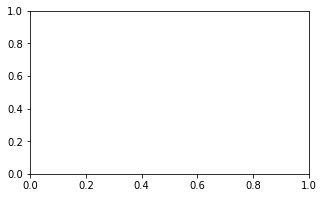

In [4]:
slope=-2#-1/4
alpha=0.2
xlabel=r'$\bar\Gamma / T$'#
ylabel=r'$\delta \hat a_{D^2} ^2$ (cm$^2$/s)'
#DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# DONE: simple scatter plot
fig,ax=plt.subplots(figsize=(5,3))
c_values=a_values_trgt/np.max(a_values_trgt)
for i,a in enumerate(a_values_trgt):
    plt.scatter(x_values,y_values_fk_lst[i],c='C0',linestyle='dotted',alpha=alpha*c_values[i])
    plt.scatter(x_values,y_values_lr_lst[i],c='C1',linestyle='dotted',alpha=alpha*c_values[i])
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible

#DONE: plot a token powerlaw that is positive and monotonically decreasing 
#HINT: y = M * x **-nu for nu as the negative slope
xv=np.logspace(-3,0,100)
yv=1.5e0*xv**slope
plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
plt.yscale('log')
plt.ylim([1e-4,1e7])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e2, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(5,3))
c_values=a_values_trgt/np.max(a_values_trgt)
for i,a in enumerate(a_values_trgt):
    ax.scatter(x_values,y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i])
    ax.scatter(x_values,y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i])
 
# TODO: each colored by a_values_trgt 
# TODO: on a scale with both ends clearly visible

# #DONE: plot a token powerlaw that is positive and monotonically decreasing 
# #HINT: y = M * x **-nu for nu as the negative slope
# xv=np.logspace(-3,0,100)
# yv=1.5e-1*xv**slope
# plt.plot(xv,yv,'k--',alpha=.6)

#format_plot
# plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# plt.yscale('log')
plt.ylim([-4,4e0])
format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=False, fontsize=18)#, **kwargs)
# format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
# mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
plt.show()
print(f"TODO: change the variable a lines to use two clearly distinguishable color schemes that end at both ends as clearly distinguishable from white background")
print(F"TODO: add blue and orange curves for the a values expected of the full solution")

In [ ]:
#TODO: change ^this plot to only use give values for a_hat_lr and a_hat_fk
# slope=-2#-1/4
# alpha=0.2
# xlabel=r'$\bar\Gamma / T$'#
# ylabel=r'$\delta \hat a_{D^2} ^2/a^2$ (cm$^2$/s)'
# #DONE: plot x_values,y_values_fk_lst,y_values_lr_lst, 
# # DONE: simple scatter plot
# fig,ax=plt.subplots(figsize=(5,3))
# c_values=a_values_trgt/np.max(a_values_trgt)
# for i,a in enumerate(a_values_trgt):
#     plt.scatter(x_values,y_values_fk_lst[i]/(a**2),c='C0',linestyle='dotted',alpha=alpha*c_values[i])
#     plt.scatter(x_values,y_values_lr_lst[i]/(a**2),c='C1',linestyle='dotted',alpha=alpha*c_values[i])
# # TODO: each colored by a_values_trgt 
# # TODO: on a scale with both ends clearly visible

# # #DONE: plot a token powerlaw that is positive and monotonically decreasing 
# # #HINT: y = M * x **-nu for nu as the negative slope
# # xv=np.logspace(-3,0,100)
# # yv=1.5e-1*xv**slope
# # plt.plot(xv,yv,'k--',alpha=.6)

# #format_plot
# # plt.title('Colors deepen with increasing a>0\n',fontsize=14)
# # plt.yscale('log')
# # plt.ylim([1e-4,1e7])
# # format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=False, fontsize=18)#, **kwargs)
# # format_plot(ax=plt.gca(), xlabel=xlabel, ylabel=ylabel, use_loglog=True, fontsize=18)#, **kwargs)
# # mark_slope(ax=plt.gca(), x1=1e-1, y1=2.5e1, slope=(-2,1), text_kwargs={'color': 'black'}, poly_kwargs={'facecolor': (0.0, 0.0, 0)})
# plt.show()

In [ ]:
# def mark_slope(ax, x1, y1, slope=(2, 1),
#         text_kwargs={'color': 'black'},
#         poly_kwargs={'facecolor': (0., 0., 0)},
#         **kwargs):
#     '''all parameters are passed to mpltools.annotation.slope_marker
#     slope can equivalently be, for example, 2 or (2,1).

#     Example Usage:
# mark_slope(ax, x1, y1)
# #...or better yet
# annotation.slope_marker(origin=(x1, y1),
#                         slope=3,#(3, 1),
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)
#     '''
#     annotation.slope_marker(origin=(x1, y1),
#                             slope=slope,
#                             text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                             poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                             ax=ax)
#     return True

In [ ]:
#TODO(later): plot the ratio of the difference between lr and fk for the diffusion correction to ahat_squared

In [5]:
#TODO(Now!): plot the cross correction to ahat_squared